In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
import scipy
from corrections import pattern_correction, lowpass
from tqdm import tqdm
import os

In [2]:
t_width = 1.6
t = np.arange(-5000 * t_width, 5000*t_width, t_width)  

## Plot of $G^{(2)}$ and normalised version $g^{(2)}$ 

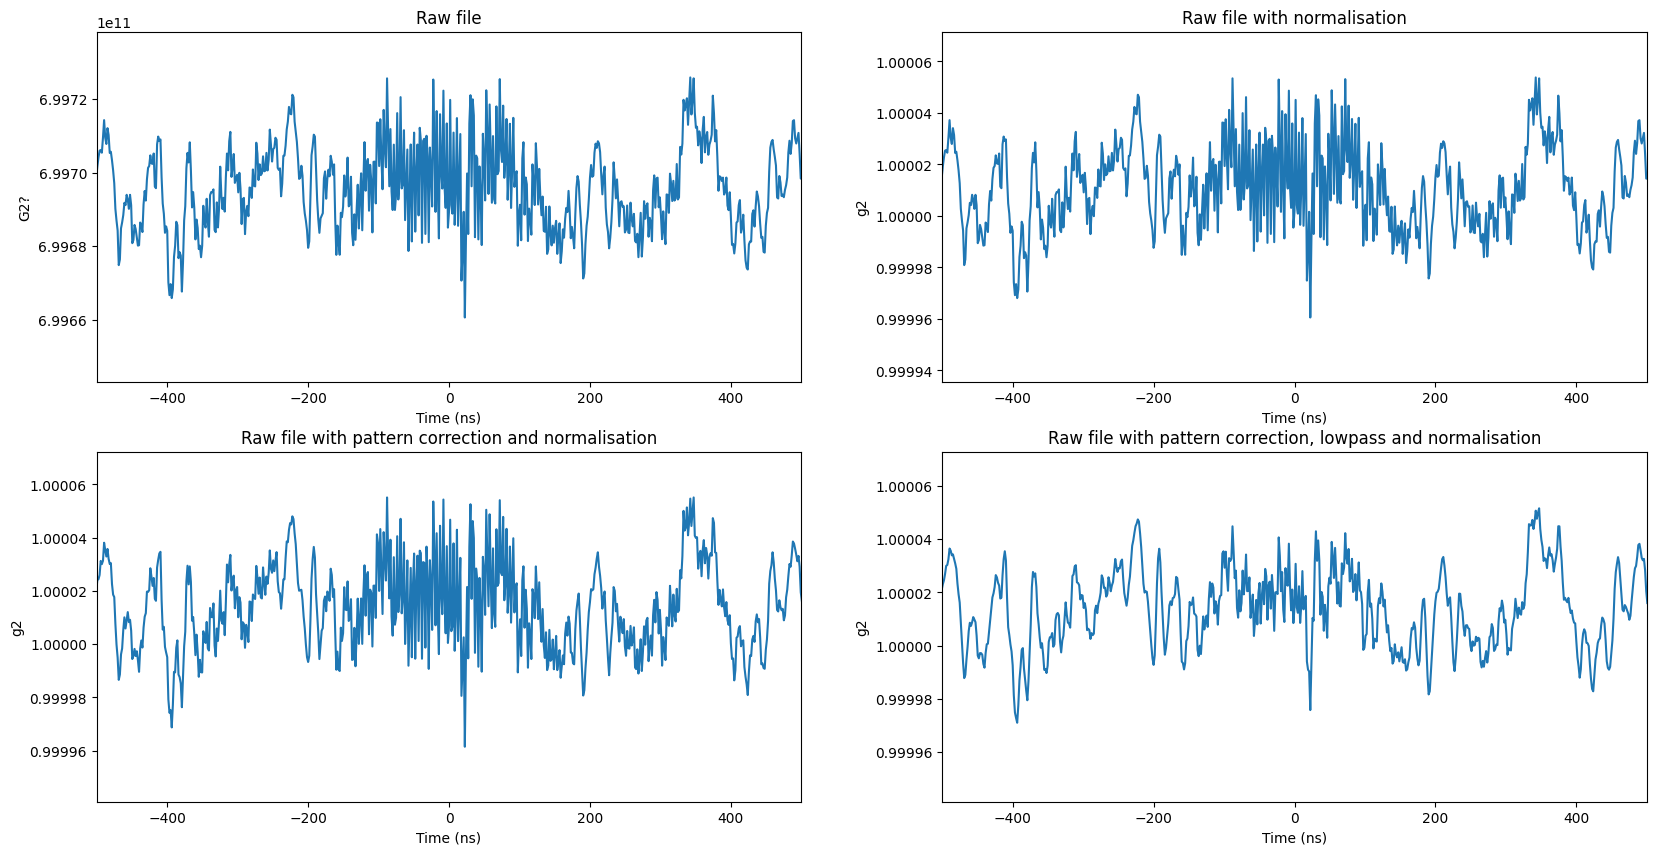

In [3]:
%matplotlib inline
meas_number = 0
path = 'corr_data\measurement_' + str(meas_number).zfill(5) + '.fcorr'
data = np.loadtxt(path)
t_width = 1.6

fig, ax = plt.subplots(ncols = 2, nrows=2, figsize=(20, 10))
ax[0,0].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), data)
ax[0,0].set(xlabel='Time (ns)', ylabel='G2?', title='Raw file', xlim=[-500,500])
ax[0,1].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), data/np.mean(data))
ax[0,1].set(xlabel='Time (ns)', ylabel='g2', title='Raw file with normalisation', xlim=[-500,500])
ax[0,1].ticklabel_format(useOffset=False)

# Apply pattern correction
ax[1,0].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), pattern_correction(data))
ax[1,0].set(xlabel='Time (ns)', ylabel='g2', title='Raw file with pattern correction and normalisation', xlim=[-500,500])
ax[1,0].ticklabel_format(useOffset=False)
#And lowpass
ax[1,1].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), lowpass(pattern_correction(data)))
ax[1,1].set(xlabel='Time (ns)', ylabel='g2', title='Raw file with pattern correction, lowpass and normalisation', xlim=[-500,500])
ax[1,1].ticklabel_format(useOffset=False)

## Fourier transform

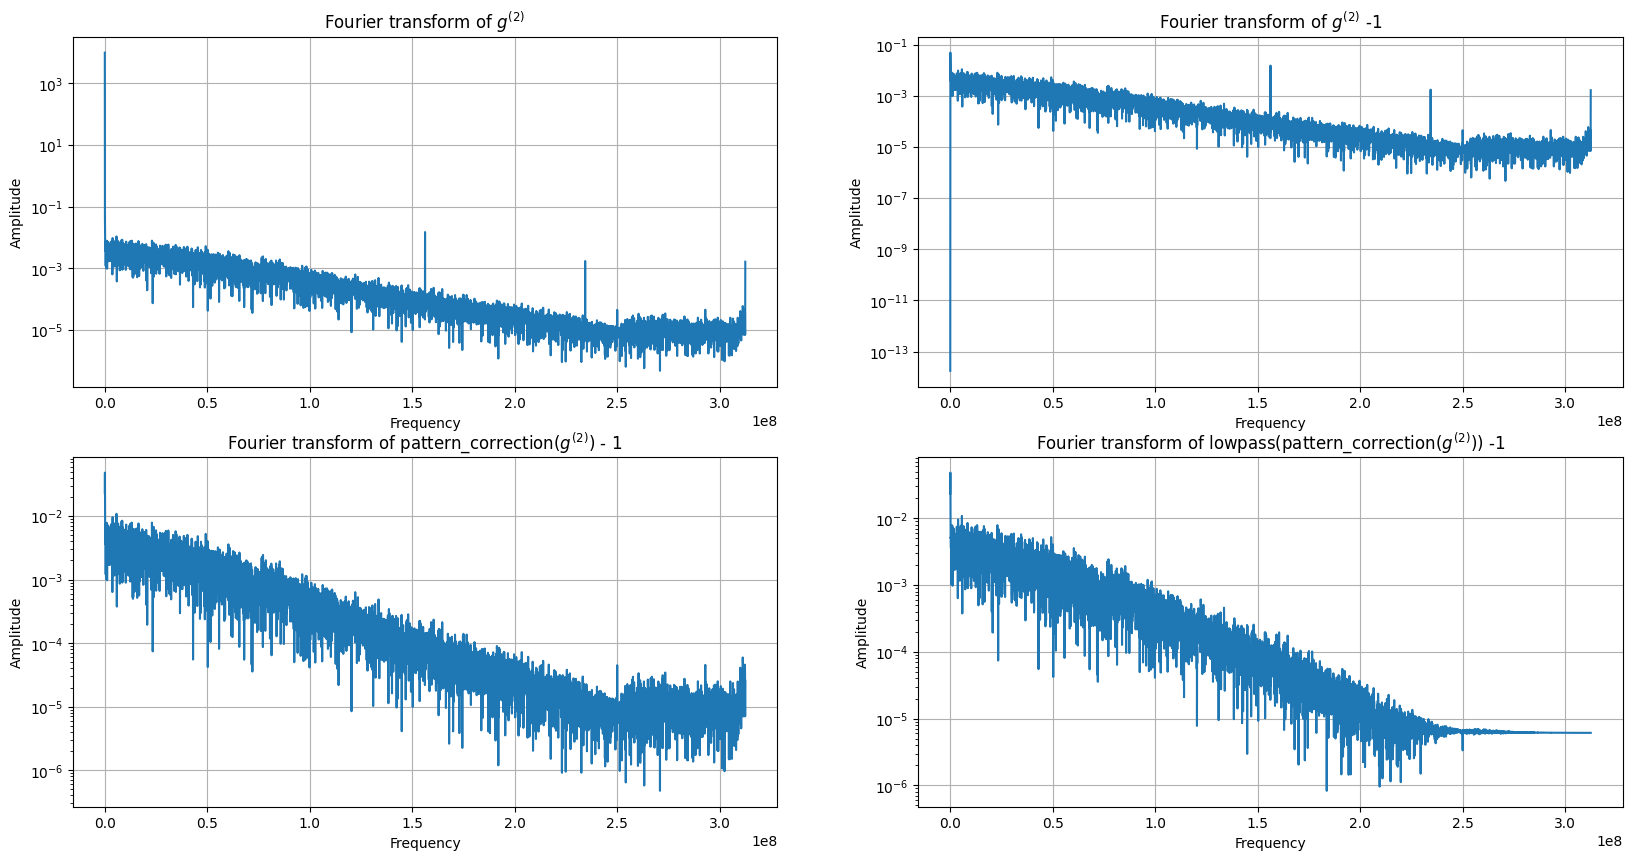

In [4]:
%matplotlib inline
meas_number = 20
path = 'corr_data\measurement_' + str(meas_number).zfill(5) + '.fcorr'


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
data = np.loadtxt(path)
data = data/np.mean(data) 
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[0,0].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[0,0].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of $g^{(2)}$');
ax[0,0].grid()

data = np.loadtxt(path)
data = data/ np.mean(data) -1
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[0,1].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[0,1].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of $g^{(2)}$ -1');
ax[0,1].grid()

data = np.loadtxt(path)
data = pattern_correction(data) - 1
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[1,0].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[1,0].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of pattern_correction($g^{(2)}$) - 1');
ax[1,0].grid()

data = np.loadtxt(path)
data = lowpass(pattern_correction(data)) - 1
fourier = np.fft.rfft(data)
frequencies = np.fft.rfftfreq(len(data), t_width*1e-9)
ax[1,1].plot(frequencies, np.abs(fourier)) # Absolute or real value?
ax[1,1].set(xlabel='Frequency', ylabel='Amplitude', yscale='log', title='Fourier transform of lowpass(pattern_correction($g^{(2)}$)) -1');
ax[1,1].grid()

## How to average?

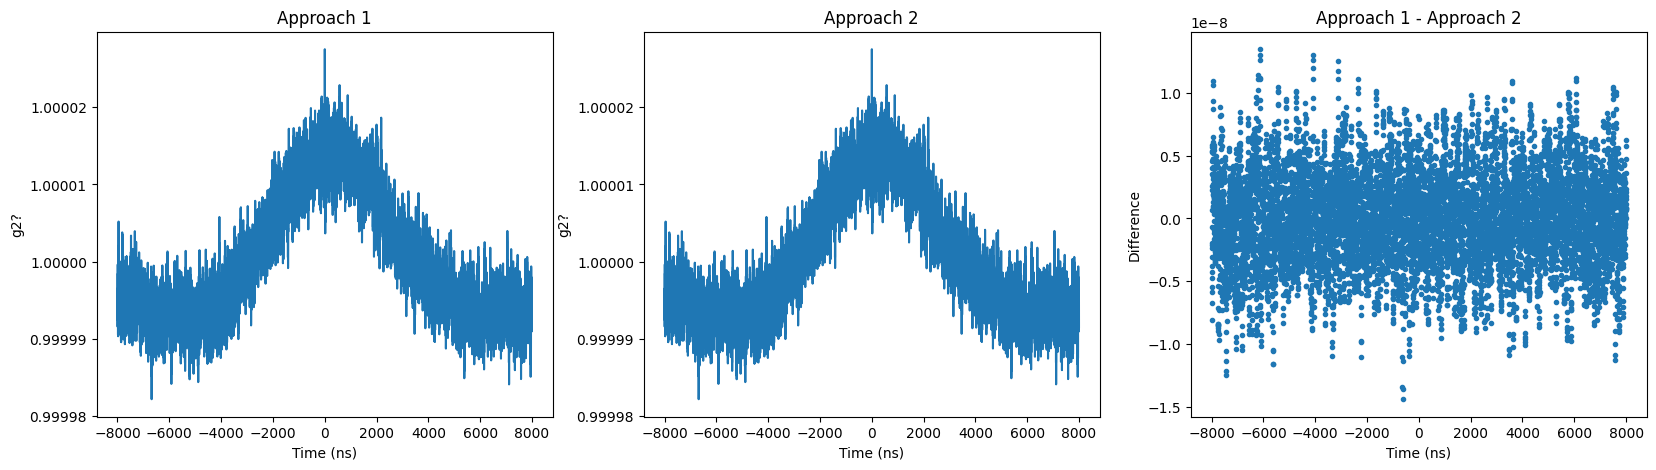

In [5]:
%matplotlib inline
# 1st approach: Add all correlation data, then Nomralise
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data
average_1 = sum/np.mean(sum)

# 2nd approach: Normalise each correlation data, then add and normalise again
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data/np.mean(data)
average_2 = sum/np.mean(sum)

# Plot
fig, ax = plt.subplots(ncols = 3, figsize=(20, 5))
ax[0].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_1)
ax[0].set(xlabel='Time (ns)', ylabel='g2?', title='Approach 1')
ax[0].ticklabel_format(useOffset=False)
ax[1].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_2)
ax[1].set(xlabel='Time (ns)', ylabel='g2?', title='Approach 2')
ax[1].ticklabel_format(useOffset=False)
ax[2].plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_1 - average_2, '.')
ax[2].set(xlabel='Time (ns)', ylabel='Difference', title='Approach 1 - Approach 2')
ax[2].ticklabel_format(useOffset=False)

## Combine pattern_correction lowpass and average over 40 measurements 
Uses weighted mean: 
\begin{equation*}
\bar{x} = \frac{\sum \frac{\vec{x}}{\sigma_{x}^2}}{\sum \sigma_{x}^{-2}}
\end{equation*}

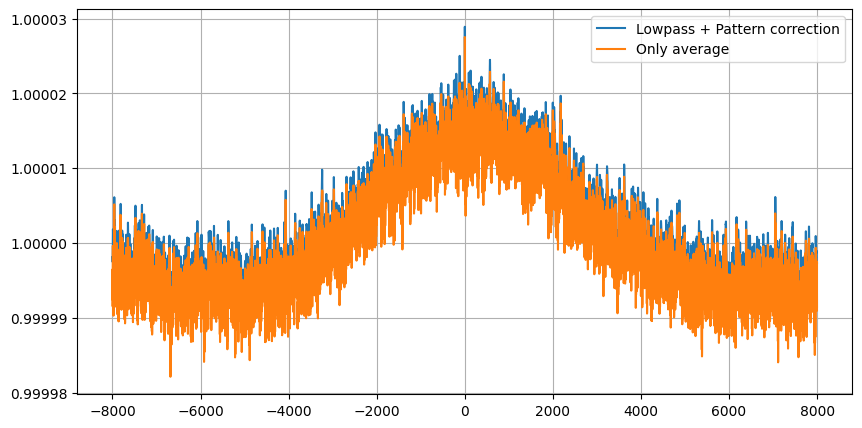

In [6]:
%matplotlib inline
sum = np.zeros(10000)
weight_sum = 0
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    data = lowpass(pattern_correction(data))
    weight = 1
    sum += data*weight
    weight_sum += weight
average = sum/weight_sum

fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average, label= 'Lowpass + Pattern correction')

# Raw averaged data w/o lowpass, pattern correction
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data/np.mean(data)
average_2 = sum/np.mean(sum)
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), average_2, label= 'Only average')

ax.ticklabel_format(useOffset=False)
#ax.set(xlim=[-300,300])
ax.legend()
ax.grid()

## Try applying lowpass to individual raw data

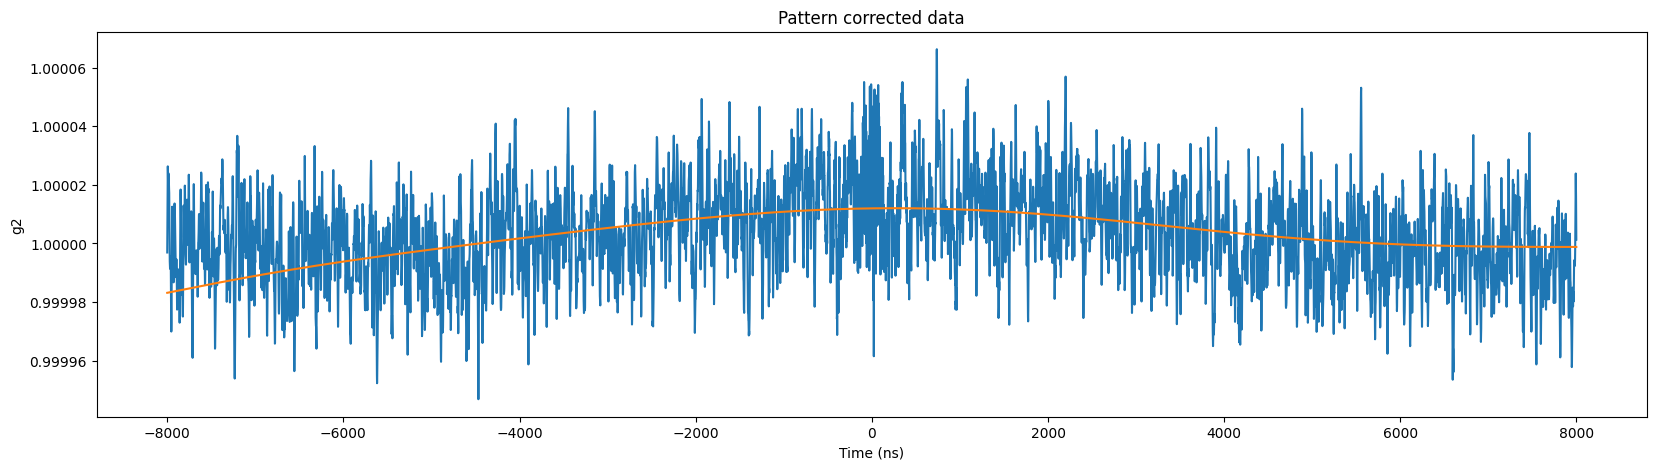

In [7]:
%matplotlib inline
meas_number = 0
path = 'corr_data\measurement_' + str(meas_number).zfill(5) + '.fcorr'
data = np.loadtxt(path)
data = pattern_correction(data)
cutoff_freq = 1e-4
lowpass_data = lowpass(data, cutoff_freq)

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), data)
ax.set(xlabel='Time (ns)', ylabel='g2', title='Pattern corrected data')
ax.ticklabel_format(useOffset=False)
ax.plot(np.arange(-5000 * t_width, 5000*t_width, t_width), lowpass_data)


## Lowpass before pattern correction - 29.5. --> Idea discontinued

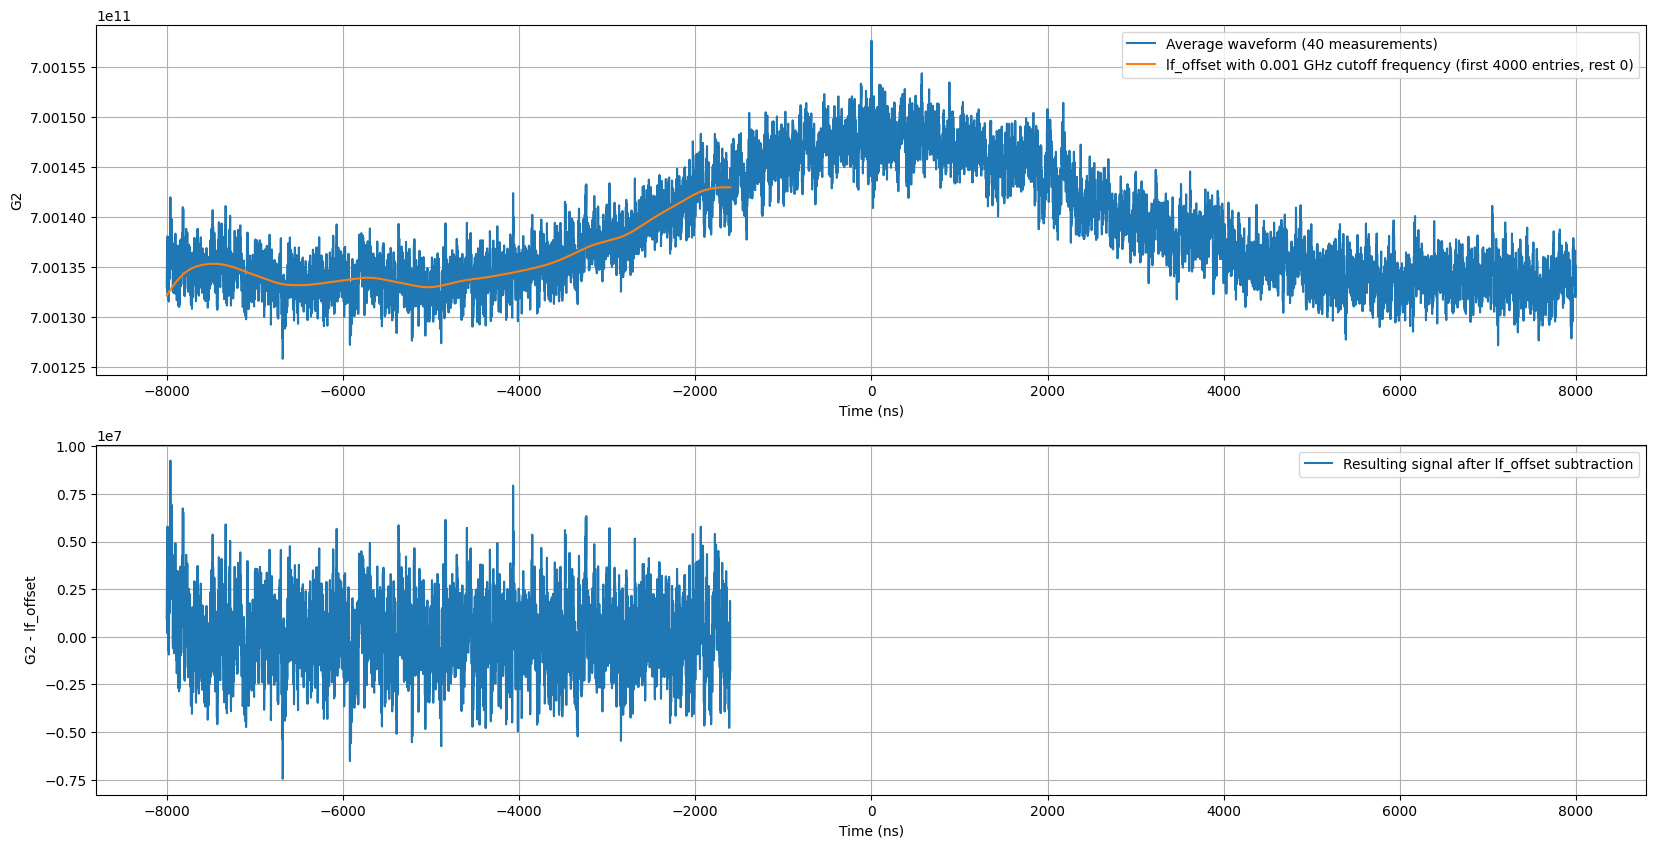

In [8]:
%matplotlib inline
# First: Average over all measurements to get "stable" lf-peak
sum = np.zeros(10000)
for n in range(41): 
    path = 'corr_data\measurement_' + str(n).zfill(5) + '.fcorr'
    data = np.loadtxt(path)
    sum += data
mean_waveform_with_offset = sum/41
# Apply lowpass to the first 4000 bins
cutoff_freq = 1e-3 #GHz
lf_offset = lowpass(mean_waveform_with_offset[:4000], cutoff_freq)
# Append 0 for it beeing the same length as raw data files for subtraction:
lf_offset = np.append(lf_offset, np.zeros_like(mean_waveform_with_offset[4000:]))


# Plot for visualisation
t = np.arange(-5000 * t_width, 5000*t_width, t_width)             
pattern_data = mean_waveform_with_offset - lf_offset
fig, ax = plt.subplots(nrows = 2, figsize=(20, 10))
ax[0].plot(t, mean_waveform_with_offset, label='Average waveform (40 measurements)')
ax[0].plot(t[:4000], lf_offset[:4000], label='lf_offset with {} GHz cutoff frequency (first 4000 entries, rest 0)'.format(cutoff_freq))
ax[0].set(xlabel='Time (ns)', ylabel='G2')
ax[0].ticklabel_format(useOffset=False)
ax[0].grid()
ax[0].legend()
ax[1].sharex(ax[0])
ax[1].plot(t[:4000], pattern_data[:4000], label='Resulting signal after lf_offset subtraction')
#ax[1].plot(t[:8], corr, label='Rest of the signal')
ax[1].set(xlabel='Time (ns)', ylabel='G2 - lf_offset')
ax[1].ticklabel_format(useOffset=False)
ax[1].grid()
ax[1].legend()


## All files...

In [9]:

def data_reduction(directory, number_data:int=None):
    ''' 
    Function that handles the data reduction of the correlation data. This includes the pattern correction, lowpass filter, normalisation and the weighted average.
    This function assumes the data is named 'measurement_XXXXX.fcorr' where XXXXX is the number of the data.
    Takes:
        - directory: str, the directory where the files are stored.
        - number_data: int, all files from 0 to number_data will be used. Default is None, which means all files in the directory will be used.
    Returns:
        - average_g2: np.array, the corrected weighted and nomralised average of all the data. 
    '''
    if number_data is None:
        number_data = count_files_in_directory(directory)
    sum = np.zeros(10000)
    weight_sum = 0
    for n in tqdm(range(number_data), desc='Do data reduction'): 
        path = directory + '\measurement_' + str(n).zfill(5) + '.fcorr'
        data = np.loadtxt(path)
        data = pattern_correction(data)
        weight = np.std(data)**-2
        sum += data*weight
        weight_sum += weight
    average_g2 = sum/weight_sum
    return lowpass(average_g2)

def count_files_in_directory(directory):
    ''' 
    Function that counts the number of files in a given directory. 
    '''
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])



# Legacy code: 
def get_lf_offset(directory, number_data, cutoff_freq=1e-3):
    ''' 
    Helper function that calculates the low frequency offset for the data reduction.
    Takes: 
        - directory: str, the directory where the files are stored.
        - number_data: int, all files from 0 to number_data will be used.
        - cutoff_freq: float, the cutoff frequency for the lowpass filter.
    Returns:
        - lf_offset: np.array, the low frequency offset for the data reduction. It contains the offset in the first 4000 bins and 0s for the rest.
    '''
    sum = np.zeros(10000)
    for n in tqdm(range(number_data), desc='Calculating low frequency offset'): 
        path = directory + '\short_' + str(n).zfill(5) + '.fcorr'
        data = np.loadtxt(path)
        sum += data
    mean_waveform_with_offset = sum/number_data
    # Apply lowpass to the first 4000 bins of the mean G2 function
    lf_offset = lowpass(mean_waveform_with_offset[:4000], cutoff_freq)
    # Append 0s for it beeing the same length as raw data files for subtraction later:
    lf_offset = np.append(lf_offset, np.zeros_like(mean_waveform_with_offset[4000:]))
    return lf_offset

In [10]:
measurement_name  = '20240319_cable_lengths' # This corresponds to the folder name of the measurement. Nedds only to be changed for completely differnt measurements
number_measurements=count_files_in_directory('D:\\' + measurement_name) # Number of measurements to be used for the average
suffix = 'average' +'_'+ str(number_measurements) # This is the suffix of the reduced data file. It is used to distinguish between different data reduction methods.

# Only do time intensive data reduction if not already done:
if not os.path.exists('reduced_data\\' + measurement_name + '\\' + suffix + '.txt'):  
    average = data_reduction('D:\\' + measurement_name, number_measurements)
    np.savetxt('reduced_data\\' + measurement_name + '\\' + suffix + '.txt', average)
else:
    average = np.loadtxt('reduced_data\\' + measurement_name + '\\' + suffix + '.txt')

## Try fitting correlation peak template 

3.680029916636903e-08


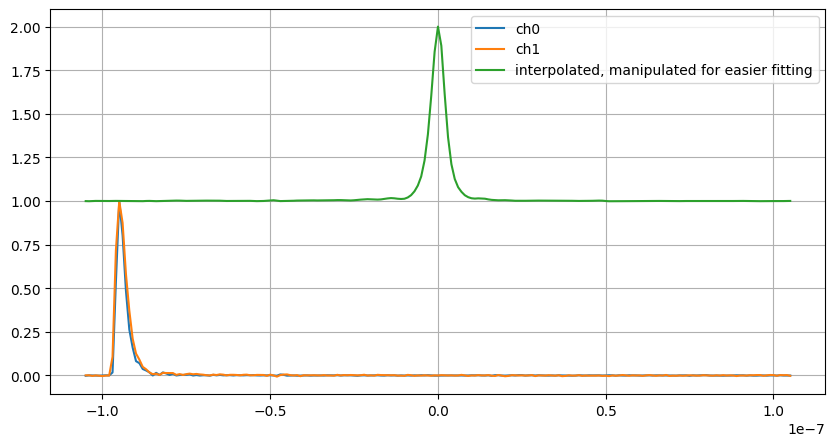

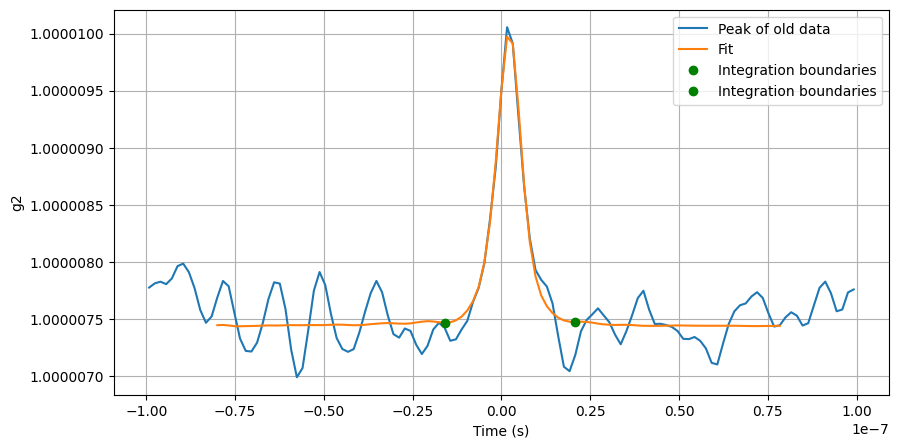

In [11]:
data = np.loadtxt('reduced_data\\20240319_cable_lengths\\average_7251.txt') # Old data from Andi
t = np.arange(-5000 * t_width, 5000*t_width, t_width)*1e-9
centre_mask = np.logical_and(t > -100e-9, t < 100e-9) # Mask for only plotting peak centre
fit_mask = np.logical_and(t > -80e-9, t < 80e-9) # Mask for fitting the peak

# Load the shape of the single photon pulses from calib files
shape0 =  np.loadtxt('D:\\20240319_cable_lengths\\calibs_ch0\\calib.shape1')
shape1 = np.loadtxt('D:\\20240319_cable_lengths\\calibs_ch1\\calib.shape1')
# Correlation and normalisation/shifting for easier fitting
pulse = scipy.signal.correlate(shape0[:,1], shape1[:,1], mode='same')
pulse= pulse/np.max(pulse) +1
x = np.arange(0,211)*1e-9
x = x - x[np.argmax(pulse)]

# Interpolation, and fitting
y = scipy.interpolate.interp1d(x, pulse, fill_value='extrapolate', kind='linear')
def fit_func(x, a, b, c, d):
    return a*y(b*x - c) +d
p0 = [3e-6, 1, 0, 10]
popt, pcov = scipy.optimize.curve_fit(fit_func, t[fit_mask], data[fit_mask], p0=p0)

# Find the local minima next to the peak as integration boundaries
local_minima = scipy.signal.argrelmin(fit_func(t[fit_mask], *popt))[0]
minima_threshold = 0.25e-7
# only keep minima that are close to the peak, adjust threshold if necessary
local_minima = [m for m in local_minima if np.abs(t[fit_mask][m]) < minima_threshold]

# Do the integration
lower_bound = t[fit_mask][local_minima[0]]
upper_bound = t[fit_mask][local_minima[1]]
integral, error_estimate = scipy.integrate.quad(fit_func, lower_bound, upper_bound, args=tuple(popt))
print(integral)

# Plotting
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(x, shape0[:,1], label='ch0')
ax.plot(x, shape1[:,1], label='ch1')
ax.plot(x, y(x), label='interpolated, manipulated for easier fitting')
ax.grid()
ax.legend()
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(t[centre_mask], data[centre_mask], label='Peak of old data')
ax.plot(t[fit_mask], fit_func(t[fit_mask], *popt), label='Fit')
for i in local_minima:
    ax.plot(t[fit_mask][i], fit_func(t[fit_mask][i], *popt), 'go', label='Integration boundaries')
ax.set(xlabel='Time (s)', ylabel='g2')
ax.ticklabel_format(useOffset=False)
ax.grid() 
ax.legend()

## New test data from 5.6. - See if 78MHZ artifact is still present 

In [12]:
measurement_name = '20240605_10x10test'
num = 1000
filename = 'average' + str(num) # This is the filename of the reduced data file. can be used to distinguish between different data reduction methods.
# Only do time intensive data reduction if not already done:
if not os.path.exists('reduced_data\\' + measurement_name + '\\' + filename + '.txt'):  
    average = data_reduction('D:\\' + measurement_name, num)
    if not os.path.exists('reduced_data\\' + measurement_name):
        os.makedirs('reduced_data\\' + measurement_name)
    np.savetxt('reduced_data\\' + measurement_name + '\\' + filename + '.txt', average)
else:
    average = np.loadtxt('reduced_data\\' + measurement_name + '\\' + filename + '.txt')

[Text(0.5, 0, 'Frequency (GHz)'), Text(0, 0.5, 'Amplitude'), None]

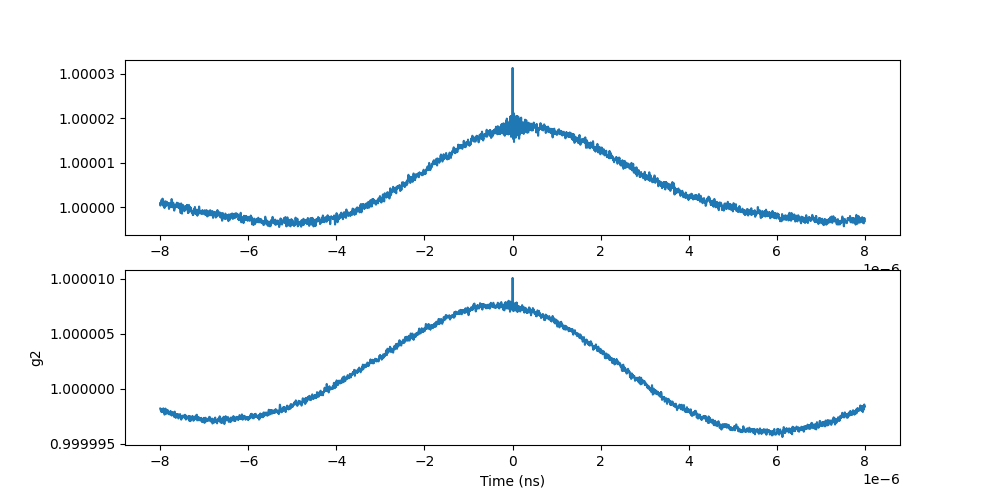

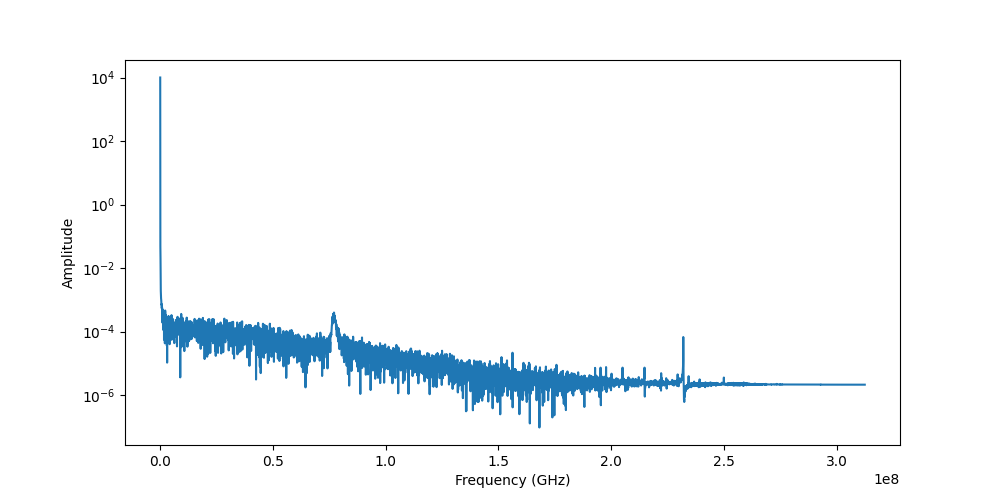

In [13]:
%matplotlib widget
old_data_average = np.loadtxt('reduced_data\\20240319_cable_lengths\\average_7251.txt')
fig,ax = plt.subplots(nrows =2, figsize=(10, 5))
ax[0].plot(t, average)
ax[0].ticklabel_format(useOffset=False)
ax[1].set(xlabel='Time (ns)', ylabel='g2')
ax[1].plot(t, old_data_average)
ax[0].sharex(ax[1])
ax[1].ticklabel_format(useOffset=False)
fourier = np.fft.rfft(average)
frequencies = np.fft.rfftfreq(len(average), t_width*1e-9)
fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(frequencies, np.abs(fourier))
ax.set(xlabel='Frequency (GHz)', ylabel='Amplitude', yscale='log')

[Text(0.5, 0, 'Frequency (GHz)'), Text(0, 0.5, 'Amplitude'), None]

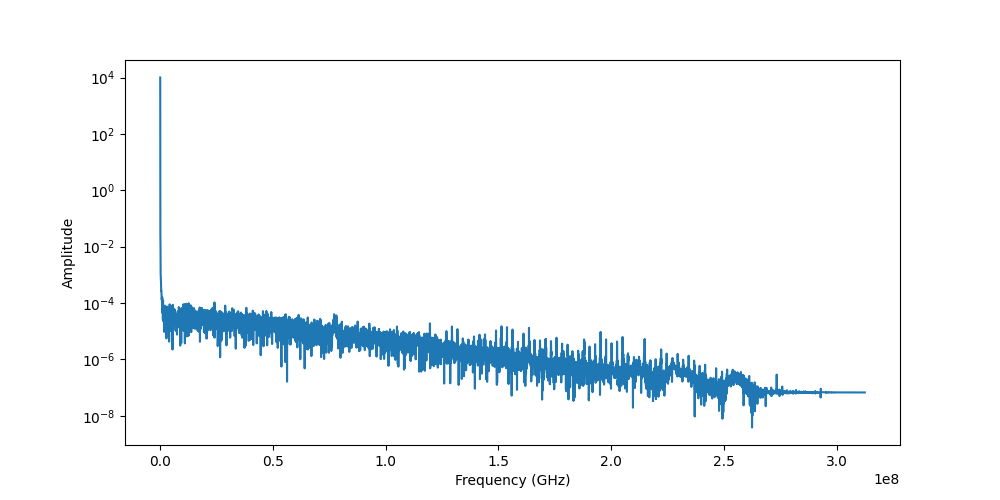

In [14]:

fourier = np.fft.rfft(old_data_average)
frequencies = np.fft.rfftfreq(len(old_data_average), t_width*1e-9)

fig,ax = plt.subplots(figsize=(10, 5))
ax.plot(frequencies, np.abs(fourier))
ax.set(xlabel='Frequency (GHz)', ylabel='Amplitude', yscale='log')
